# Model

## Feature Engineering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
new_df = pd.read_csv('/content/drive/My Drive/new_home_credit_dataset.csv')

In [ ]:
new_df.drop(['Unnamed: 0', 'index'], axis = 1, inplace=True)
new_df = new_df[new_df['CODE_GENDER'] != 'XNA']
new_df = new_df[new_df['AMT_INCOME_TOTAL'] < 20000000] # remove a outlier 117M
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
new_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # set null value
new_df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True) # set null value

def get_age_label(days_birth):
        """ Return the age group label (int). """
        age_years = -days_birth / 365
        if age_years < 27: return 1
        elif age_years < 40: return 2
        elif age_years < 50: return 3
        elif age_years < 65: return 4
        elif age_years < 99: return 5
        else: return 0
    # Categorical age - based on target=1 plot
new_df['AGE_RANGE'] = new_df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

new_df['DAYS_EMPLOYED_PERC'] = new_df['DAYS_EMPLOYED'] / new_df['DAYS_BIRTH']
new_df['INCOME_CREDIT_PERC'] = new_df['AMT_INCOME_TOTAL'] / new_df['AMT_CREDIT']
new_df['PHONE_TO_BIRTH_RATIO'] = new_df['DAYS_LAST_PHONE_CHANGE'] / new_df['DAYS_BIRTH']
new_df['APPS_GOODS_INCOME_RATIO'] = new_df['AMT_GOODS_PRICE'] / new_df['AMT_INCOME_TOTAL']
new_df['APPS_INCOME_EMPLOYED_RATIO'] = new_df['AMT_INCOME_TOTAL'] / new_df['DAYS_EMPLOYED']
new_df['CREDIT_TO_GOODS_RATIO_2'] = new_df['AMT_CREDIT'] / new_df['AMT_GOODS_PRICE']
new_df['APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio'] = new_df['AMT_INCOME_TOTAL'] / 12. - new_df['AMT_ANNUITY']
new_df['APP_INCOME_TO_EMPLOYED_RATIO'] = new_df['AMT_INCOME_TOTAL'] / new_df['DAYS_EMPLOYED']
new_df['APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio'] = new_df['DAYS_LAST_PHONE_CHANGE'] / new_df['DAYS_EMPLOYED']
new_df['APP_DAYS_EMPLOYED_DAYS_BIRTH_diff'] = new_df['DAYS_EMPLOYED'] - new_df['DAYS_BIRTH']
new_df['ID_TO_BIRTH_RATIO'] = new_df['DAYS_ID_PUBLISH'] / new_df['DAYS_BIRTH']

new_df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,YEARS_BEGINEXPLUATATION_MEDI,...,INSTAL_DBD_SUM,INSTAL_DBD_MIN,INSTAL_DBD_STD,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_PERC_MIN,INSTAL_PAYMENT_PERC_STD,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_DIFF_MIN,INSTAL_PAYMENT_DIFF_STD,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_INSTALMENT_STD,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_AMT_PAYMENT_STD,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_STD,INSTAL_COUNT,AGE_RANGE,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,PHONE_TO_BIRTH_RATIO,APPS_GOODS_INCOME_RATIO,APPS_INCOME_EMPLOYED_RATIO,CREDIT_TO_GOODS_RATIO_2,APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio,APP_INCOME_TO_EMPLOYED_RATIO,APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio,APP_DAYS_EMPLOYED_DAYS_BIRTH_diff,ID_TO_BIRTH_RATIO
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,0.9722,0.0833,0.0190,0.9722,0.0833,0.0198,0.9722,...,388.0,12.0,4.925171,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,53093.745,11559.247105,219625.695,9251.775,10058.037722,9251.775,53093.745,11559.247105,219625.695,10058.037722,-49.0,-315.421053,-5993.0,172.058877,19.0,1,0.067329,0.498036,0.119860,1.733333,-317.896389,1.158397,-7825.5,-317.896389,1.780220,8824.0,0.224078
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,NaN,0.9851,0.2917,0.0549,0.9851,0.2917,0.0554,0.9851,...,179.0,1.0,3.726929,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,560835.360,64754.586000,1618864.650,6662.970,110542.592300,6662.970,560835.360,64754.586000,1618864.650,110542.592300,-544.0,-1385.320000,-34633.0,757.325432,25.0,3,0.070862,0.208736,0.049389,4.183333,-227.272727,1.145199,-13198.5,-227.272727,0.696970,15577.0,0.017358
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,3.0,4.163332,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,10573.965,7096.155000,21288.465,5357.250,3011.871810,5357.250,10573.965,7096.155000,21288.465,3011.871810,-727.0,-761.666667,-2285.0,34.019602,3.0,4,0.011814,0.500000,0.042791,2.000000,-300.000000,1.000000,-1125.0,-300.000000,3.622222,18821.0,0.132889
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,310.0,1.0,25.397835,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,691786.890,62947.088438,1007153.415,2482.920,168097.624347,2482.920,691786.890,62947.088438,1007153.415,168097.624347,-12.0,-271.625000,-4346.0,198.045744,16.0,4,0.159905,0.431748,0.032465,2.200000,-44.422507,1.052803,-18436.5,-44.422507,0.203027,15966.0,0.128229
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0

In [ ]:
app_train = new_df[new_df['TARGET'].notnull()].copy()
app_test = new_df[new_df['TARGET'].isnull()].copy()
app_train = app_train.replace([np.inf, -np.inf], np.nan)
app_train = app_train.reset_index()
app_train.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,...,INSTAL_DBD_SUM,INSTAL_DBD_MIN,INSTAL_DBD_STD,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_PERC_MIN,INSTAL_PAYMENT_PERC_STD,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_DIFF_MIN,INSTAL_PAYMENT_DIFF_STD,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_INSTALMENT_MIN,INSTAL_AMT_INSTALMENT_STD,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_AMT_PAYMENT_STD,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_STD,INSTAL_COUNT,AGE_RANGE,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,PHONE_TO_BIRTH_RATIO,APPS_GOODS_INCOME_RATIO,APPS_INCOME_EMPLOYED_RATIO,CREDIT_TO_GOODS_RATIO_2,APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio,APP_INCOME_TO_EMPLOYED_RATIO,APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio,APP_DAYS_EMPLOYED_DAYS_BIRTH_diff,ID_TO_BIRTH_RATIO
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,0.9722,0.0833,0.0190,0.9722,0.0833,0.0198,...,388.0,12.0,4.925171,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,53093.745,11559.247105,219625.695,9251.775,10058.037722,9251.775,53093.745,11559.247105,219625.695,10058.037722,-49.0,-315.421053,-5993.0,172.058877,19.0,1,0.067329,0.498036,0.119860,1.733333,-317.896389,1.158397,-7825.5,-317.896389,1.780220,8824.0,0.224078
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,NaN,0.9851,0.2917,0.0549,0.9851,0.2917,0.0554,...,179.0,1.0,3.726929,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,560835.360,64754.586000,1618864.650,6662.970,110542.592300,6662.970,560835.360,64754.586000,1618864.650,110542.592300,-544.0,-1385.320000,-34633.0,757.325432,25.0,3,0.070862,0.208736,0.049389,4.183333,-227.272727,1.145199,-13198.5,-227.272727,0.696970,15577.0,0.017358
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,3.0,4.163332,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,10573.965,7096.155000,21288.465,5357.250,3011.871810,5357.250,10573.965,7096.155000,21288.465,3011.871810,-727.0,-761.666667,-2285.0,34.019602,3.0,4,0.011814,0.500000,0.042791,2.000000,-300.000000,1.000000,-1125.0,-300.000000,3.622222,18821.0,0.132889
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,310.0,1.0,25.397835,1.0,1.000000,0.000000,1.00000,0.000000,0.000,0.000000,0.000000e+00,0.0,0.000000,691786.890,62947.088438,1007153.415,2482.920,168097.624347,2482.920,691786.890,62947.088438,1007153.415,168097.624347,-12.0,-271.625000,-4346.0,198.045744,16.0,4,0.159905,0.431748,0.032465,2.200000,-44.422507,1.052803,-18436.5,-44.422507,0.203027,15966.0,0.128229
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.322738,NaN,NaN,NaN,NaN,NaN

In [ ]:
# Với biến chỉ có 2 giá trị, dùng label encoding, nếu nhiều hơn thì chuyển sang encoding rồi dùng one-hot encoding 
# Create a label encoder object
le = LabelEncoder()
le_count = 0
lst_name = []
# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            lst_name.append(col)
            # Keep track of how many columns were label encoded
            le_count += 1
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [ ]:
# apply one-hot encoding với các biến đã dùng label encoding, trong pd dùng get_dummies, trong scikit learn là one hot encoding
#one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307506, 535)
Testing Features shape:  (48744, 534)


In [ ]:
top_features = [
'CODE_GENDER', 'NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
'NEW_SCORES_STD','BURO_DAYS_CREDIT_VAR','DAYS_ID_PUBLISH',
'DAYS_BIRTH','DAYS_REGISTRATION','DAYS_EMPLOYED',
'NEW_EMPLOY_TO_BIRTH_RATIO', 'PREV_APP_CREDIT_PERC_MEAN','CLOSED_AMT_CREDIT_SUM_SUM',
'CLOSED_DAYS_CREDIT_VAR','LIVINGAREA_MEDI','NAME_EDUCATION_TYPE_Higher education',
'DAYS_LAST_PHONE_CHANGE','AMT_GOODS_PRICE','AMT_CREDIT'
]
Second_features=['LIVINGAREA_AVG','FLOORSMAX_AVG','FLOORSMAX_MODE','FLOORSMAX_MEDI','AMT_INCOME_TOTAL','AMT_ANNUITY','FLAG_PHONE',
                'REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT'] 

fearure_engineering_feas = ['DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'PHONE_TO_BIRTH_RATIO', 'APPS_GOODS_INCOME_RATIO', 'APPS_INCOME_EMPLOYED_RATIO', 'CREDIT_TO_GOODS_RATIO_2',
'APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio', 'APP_INCOME_TO_EMPLOYED_RATIO', 'APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio',
'APP_DAYS_EMPLOYED_DAYS_BIRTH_diff', 'ID_TO_BIRTH_RATIO']

In [ ]:
#app_train_top_features = pd.DataFrame
app_train_top_features = app_train[top_features + Second_features + fearure_engineering_feas+['TARGET']].copy()

app_train_top_features.head()                                                   

,CODE_GENDER,NEW_EXT_SOURCES_MEAN,EXT_SOURCE_3,EXT_SOURCE_2,NEW_SCORES_STD,BURO_DAYS_CREDIT_VAR,DAYS_ID_PUBLISH,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_EMPLOYED,NEW_EMPLOY_TO_BIRTH_RATIO,PREV_APP_CREDIT_PERC_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_DAYS_CREDIT_VAR,LIVINGAREA_MEDI,NAME_EDUCATION_TYPE_Higher education,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,AMT_CREDIT,LIVINGAREA_AVG,FLOORSMAX_AVG,FLOORSMAX_MODE,FLOORSMAX_MEDI,AMT_INCOME_TOTAL,AMT_ANNUITY,FLAG_PHONE,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,PHONE_TO_BIRTH_RATIO,APPS_GOODS_INCOME_RATIO,APPS_INCOME_EMPLOYED_RATIO,CREDIT_TO_GOODS_RATIO_2,APP_AMT_INCOME_TOTAL_12_AMT_ANNUITY_ratio,APP_INCOME_TO_EMPLOYED_RATIO,APP_DAYS_LAST_PHONE_CHANGE_DAYS_EMPLOYED_ratio,APP_DAYS_EMPLOYED_DAYS_BIRTH_diff,ID_TO_BIRTH_RATIO,TARGET
0,0,0.161787,0.139376,0.262949,0.092026,186150.000000,-2120,-9461,-3648.0,-637.0,0.067329,1.000000,383067.0,123956.700000,0.0193,0,-1134.0,351000.0,406597.5,0.0190,0.0833,0.0833,0.0833,202500.0,24700.5,1,2,2,0.067329,0.498036,0.119860,1.733333,-317.896389,1.158397,-7825.5,-317.896389,1.780220,8824.0,0.224078,1.0
1,1,0.466757,NaN,0.622246,0.219895,827783.583333,-291,-16765,-1186.0,-1188.0,0.070862,0.949329,207400.5,820590.333333,0.0558,1,-828.0,1129500.0,1293502.5,0.0549,0.2917,0.2917,0.2917,270000.0,35698.5,1,1,1,0.070862,0.208736,0.049389,4.183333,-227.272727,1.145199,-13198.5,-227.272727,0.696970,15577.0,0.017358,0.0
2,0,0.642739,0.729567,0.555912,0.122792,421362.000000,-2531,-19046,-4260.0,-225.0,0.011814,1.207699,189037.8,421362.000000,NaN,0,-815.0,135000.0,135000.0,NaN,NaN,NaN,NaN,67500.0,6750.0,1,2,2,0.011814,0.500000,0.042791,2.000000,-300.000000,1.000000,-1125.0,-300.000000,3.622222,18821.0,0.132889,0.0
3,1,0.650442,NaN,0.650442,0.151007,NaN,-2437,-19005,-9833.0,-3039.0,0.159905,1.010763,NaN,NaN,NaN,0,-617.0,297000.0,312682.5,NaN,NaN,NaN,NaN,135000.0,29686.5,0,2,2,0.159905,0.431748,0.032465,2.200000,-44.422507,1.052803,-18436.5,-44.422507,0.203027,15966.0,0.128229,0.0
4,0,0.322738,NaN,0.322738,0.151007,NaN,-3458,-19932,-4311.0,-3038.0,0.152418,0.969650,146250.0,NaN,NaN,0,-1106.0,513000.0,513000.0,NaN,NaN,NaN,NaN,121500.0,21865.5,0,2,2,0.152418,0.236842,0.055489,4.222222,-39.993417,1.000000,-11740.5,-39.993417,0.364055,16894.0,0.173490,0.0


In [ ]:
def preprocessing(df):
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                

                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    # one-hot encoding of categorical variables
    df = pd.get_dummies(df)
    print('Training Features shape: ', df.shape)
    from sklearn.model_selection import train_test_split
    features = df.loc[:, df.columns != 'TARGET']
    target = df.TARGET
    class_names = df.TARGET

    features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size = 0.20, random_state = 10)
    features_train.shape,features_test.shape, target_train.shape, target_test.shape
    features_train=features_train.fillna(features_train.mean())
    list_categorical=[]
    for col in features_train:
        if features_train[col].dtype == 'object'  and features_train[col].isnull().values.any():
            list_categorical.append(col)
            
            
    from sklearn_pandas import CategoricalImputer
    imputer = CategoricalImputer()
    for col in list_categorical:
        data=features_train[col]
        features_train[col]=imputer.fit_transform(data)

    features_test=features_test.fillna(features_test.mean())
    list_categorical=[]
    for col in features_test:
        if features_test[col].dtype == 'object'  and features_test[col].isnull().values.any():
            list_categorical.append(col)
            
            
    from sklearn_pandas import CategoricalImputer
    imputer = CategoricalImputer()
    for col in list_categorical:
        data=features_test[col]
        features_test[col]=imputer.fit_transform(data)
    print(features_train.shape,features_test.shape, target_train.shape, target_test.shape)
    return features_train, features_test, target_train, target_test

In [ ]:
a = app_train_top_features.copy()

In [ ]:
features_train, features_test, target_train, target_test = preprocessing(a)

0 columns were label encoded.
Training Features shape:  (307506, 40)
(246004, 39) (61502, 39) (246004,) (61502,)


In [ ]:
def _plot_roc_curve(fpr, tpr, thres):
    roc = plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', label = 'ROC')
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    return roc

## Classification Models Report

In [ ]:
'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

'''Metrics/Evaluation'''
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

In [ ]:
#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(n_estimators= 200, max_depth=15, bootstrap=True, random_state=42),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier(),
              'Logistic Regression': LogisticRegression(penalty = 'l2', C= 10),
              'LightGBM': lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)}

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, auc_score, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        if k != 'LightGBM':
            v.fit(features_train, target_train)
        else:
            v.fit(features_train, target_train, eval_metric='auc', 
                  eval_set=[(features_train, target_train),(features_test, target_test)])
        target_pred = v.predict(features_test)
        predicted_probas = v.predict_proba(features_test)
        ac_score_list.append(accuracy_score(target_test, target_pred))
        auc_score.append(roc_auc_score(target_test, predicted_probas[:,1]))
        r_score_list.append(recall_score(target_test, target_pred, average='macro'))
        f1_score_list.append(f1_score(target_test, target_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, auc_score, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'auc_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='auc_score', ascending=False)
        #print(k)
        #print(roc_auc_score(target_test, predicted_probas[:,1]))
    return model_comparison_df

model_score_df(model_dict)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[1]	training's auc: 0.729443	training's binary_logloss: 0.678021	valid_1's auc: 0.723833	valid_1's binary_logloss: 0.677891
[2]	training's auc: 0.733498	training's binary_logloss: 0.665537	valid_1's auc: 0.727519	valid_1's binary_logloss: 0.665296
[3]	training's auc: 0.736938	training's binary_logloss: 0.65512	valid_1's auc: 0.729772	valid_1's binary_logloss: 0.654849
[4]	training's auc: 0.738234	training's binary_logloss: 0.646448	valid_1's auc: 0.730797	valid_1's binary_logloss: 0.645817
[5]	training's auc: 0.739374	training's binary_logloss: 0.639084	valid_1's auc: 0.731904	valid_1's binary_logloss: 0.638248
[6]	training's auc: 0.741054	training's binary_logloss: 0.632738	valid_1's auc: 0.732699	valid_1's binary_logloss: 0.63139
[7]	training's auc: 0.742703	training's binary_logloss: 0.627212	valid_1's auc: 0.734084	valid_1's binary_logloss: 0.625886
[8]	training's auc: 0.743691	training's binary_logloss: 0.622576	valid_1's auc: 0.734638	valid_1's binary_logloss: 0.621393
[9]	traini

,model_name,accuracy_score,auc_score,recall_score,f1_score
8,LightGBM,0.724529,0.750919,0.683056,0.548799
4,AdaBoost,0.921043,0.74212,0.505597,0.491095
2,Random Forest,0.920946,0.740904,0.50245,0.484504
7,Logistic Regression,0.920751,0.618501,0.5,0.47937
5,Gaussian Naive Bayes,0.910881,0.612049,0.501766,0.490143
3,Decsision Tree,0.850883,0.542033,0.542033,0.537527
6,K Nearest Neighbor,0.91545,0.534578,0.503122,0.489917
1,Stochastic Gradient Descent,0.920734,0.499991,0.499991,0.479366
0,Dummy,0.85033,0.497761,0.497761,0.497785


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

sc = StandardScaler()
logistic = LogisticRegression()
pipe = Pipeline(steps=[('sc', sc),
                       ('logistic', logistic)])


C = [0.01, 0.1, 1, 10, 100]
# Create a list of options for the regularization penalty
penalty = ['l1', 'l2']

# Create a dictionary of all the parameter options. We can access the parameters of steps of a pipeline by using '__'

parameters = dict(logistic__C=C, logistic__penalty=penalty)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
cv = GridSearchCV(pipe, parameters, cv=10)

cv.fit(features_train, target_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
           

In [ ]:
cv.best_params_

{'logistic__C': 1, 'logistic__penalty': 'l2'}

In [ ]:
lr = LogisticRegression(penalty = 'l2', C= 10, random_state = 12)

In [ ]:
lr.fit(features_train, target_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr.predict(features_test)
predicted_probas = lr.predict_proba(features_test)

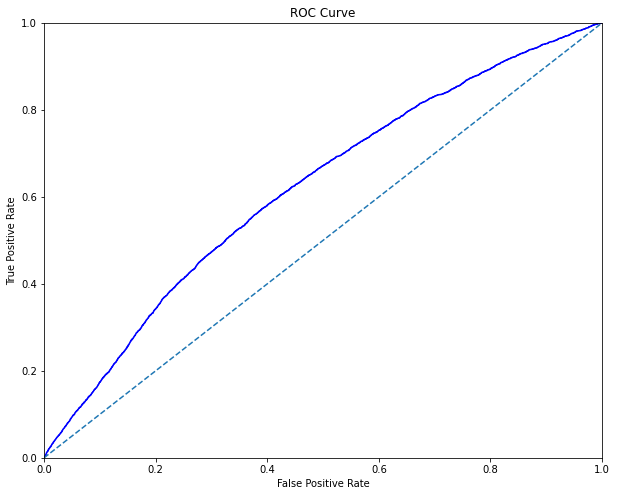

In [ ]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(target_test, predicted_probas[:,1])
  
# Lưu biểu đồ vào p1
p1 = _plot_roc_curve(fpr, tpr, thres)

In [ ]:
from sklearn.metrics import auc
#0.6667118723904264
auc(fpr, tpr)

0.6185008284926217

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(target_test, y_pred)
cnf_matrix

array([[56590,     0],
       [ 4912,     0]])

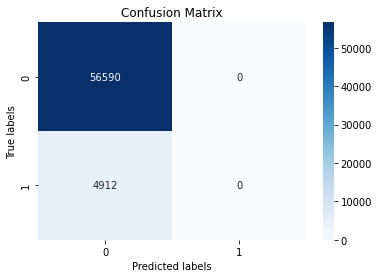

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True,cmap=plt.cm.Blues, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels((['0', '1'])); ax.yaxis.set_ticklabels(['0', '1']);

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

sc = StandardScaler()
svm = SVC()
pipe = Pipeline(steps=[('sc', sc),
                       ('SVM', svm)])

C = [0.01, 0.1, 1, 10]
gamma = ['scale', 'auto']

parameters = dict(SVM__C=C, SVM__gamma=gamma)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
cv = GridSearchCV(pipe, parameters, cv=5)

#cv.fit(features_train, target_train)

In [ ]:
cv.best_params_

{'logistic__C': 10, 'logistic__penalty': 'l2'}

In [ ]:
#Using SVM with the best parameters obtained from GridSearchCV
svm_cv=SVC(C=1,gamma='scale', kernel='linear')


In [ ]:
# Training the SVM model
svm_cv.fit(features_train, target_train)

In [ ]:
y_pred = svm_cv.predict(features_test)
predicted_probas = svm_cv.predict_proba(features_test)

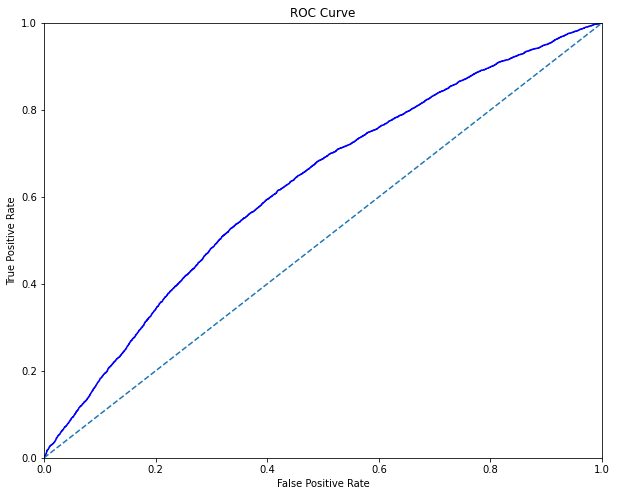

In [ ]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(target_test, predicted_probas[:,1])
  
# Lưu biểu đồ vào p1
p1 = _plot_roc_curve(fpr, tpr, thres)

In [ ]:
from sklearn.metrics import auc
#0.6667118723904264
auc(fpr, tpr)

0.6238873910458277

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(features_train, target_train)
target_pred = clf.predict(features_test)
predicted_probas = clf.predict_proba(features_test)

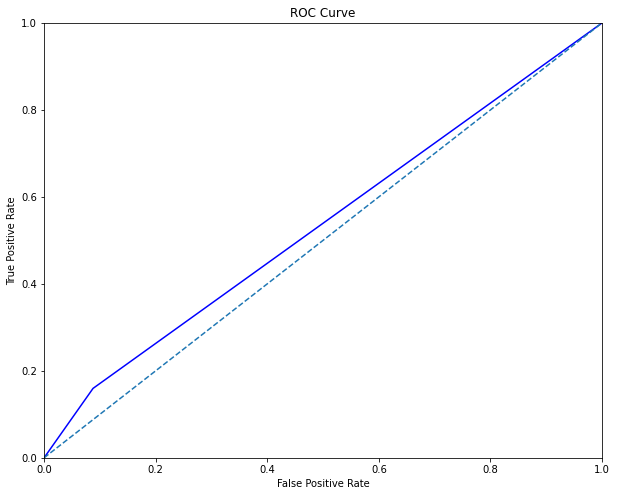

In [ ]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(target_test, predicted_probas[:,1])
  
# Lưu biểu đồ vào p1
p2 = _plot_roc_curve(fpr, tpr, thres)


In [ ]:
from sklearn.metrics import auc
#0.5421650238116087
auc(fpr, tpr)

0.5359275501881354

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(target_test, target_pred)
cnf_matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True,cmap=plt.cm.Blues, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels((['0', '1'])); ax.yaxis.set_ticklabels(['0', '1']);

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

rfr = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [5, 10, 15],
    'bootstrap': [True]
}

#Using GridSearchCV for optimal hyperparameters and noting how much time it takes to train the model

cv = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
cv.fit(features_train, target_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
cv.best_params_

{'bootstrap': True, 'max_depth': 15, 'n_estimators': 200}

In [ ]:
#Using RFR with the best parameters obtained from GridSearchCV
rfc1 = RandomForestClassifier(n_estimators= 200, max_depth=15, bootstrap=True, random_state=42)

In [ ]:
rfc1.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rfc1.predict(features_test)
predicted_probas = rfc1.predict_proba(features_test)

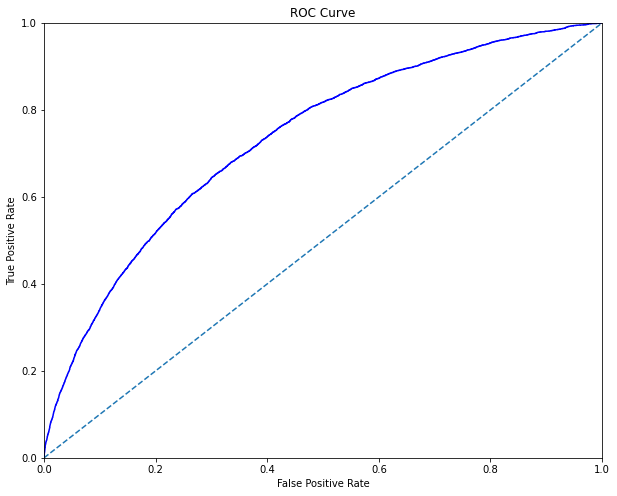

In [ ]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(target_test, predicted_probas[:,1])
  
# Lưu biểu đồ vào p1
p1 = _plot_roc_curve(fpr, tpr, thres)

In [ ]:
from sklearn.metrics import auc
#0.6667118723904264
auc(fpr, tpr)

0.7334655154252574

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(features_train, target_train)

y_pred=clf.predict(features_test)
predicted_probas=clf.predict_proba(features_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(target_test, predicted_probas[:,1])
  
# Lưu biểu đồ vào p1
p3 = _plot_roc_curve(fpr, tpr, thres)


In [ ]:
from sklearn.metrics import auc
#0.7177734130722158
auc(fpr, tpr)

In [ ]:
# Extract feature importances
features = list(a.columns)
features.remove('TARGET')
feature_importance_values = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
feature_importances_sorted = plot_feature_importances(feature_importances)

## LightGB 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import gc

In [ ]:
lgb_classifier = LGBMClassifier(nthread=-1,
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=407,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,
                            silent=-1,
                            verbose=-1,)
lgb_classifier

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.613,
               importance_type='split', learning_rate=0.01, max_bin=407,
               max_depth=11, min_child_samples=165, min_child_weight=6,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, nthread=-1,
               num_leaves=58, objective=None, random_state=None,
               reg_alpha=3.564, reg_lambda=4.93, silent=-1, subsample=0.708,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [ ]:
model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)
#model = lgb_classifier
model.fit(features_train, target_train, eval_metric='auc', 
          eval_set=[(features_train, target_train),(features_test, target_test)])

[1]	training's binary_logloss: 0.678021	training's auc: 0.729443	valid_1's binary_logloss: 0.677891	valid_1's auc: 0.723833
[2]	training's binary_logloss: 0.665537	training's auc: 0.733498	valid_1's binary_logloss: 0.665296	valid_1's auc: 0.727519
[3]	training's binary_logloss: 0.65512	training's auc: 0.736938	valid_1's binary_logloss: 0.654849	valid_1's auc: 0.729772
[4]	training's binary_logloss: 0.646448	training's auc: 0.738234	valid_1's binary_logloss: 0.645817	valid_1's auc: 0.730797
[5]	training's binary_logloss: 0.639084	training's auc: 0.739374	valid_1's binary_logloss: 0.638248	valid_1's auc: 0.731904
[6]	training's binary_logloss: 0.632738	training's auc: 0.741054	valid_1's binary_logloss: 0.63139	valid_1's auc: 0.732699
[7]	training's binary_logloss: 0.627212	training's auc: 0.742703	valid_1's binary_logloss: 0.625886	valid_1's auc: 0.734084
[8]	training's binary_logloss: 0.622576	training's auc: 0.743691	valid_1's binary_logloss: 0.621393	valid_1's auc: 0.734638
[9]	traini

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=22, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
# Predict the probability score
#prob_train = model.predict_proba(X_train_scaled)
predicted_probas = model.predict_proba(features_test)

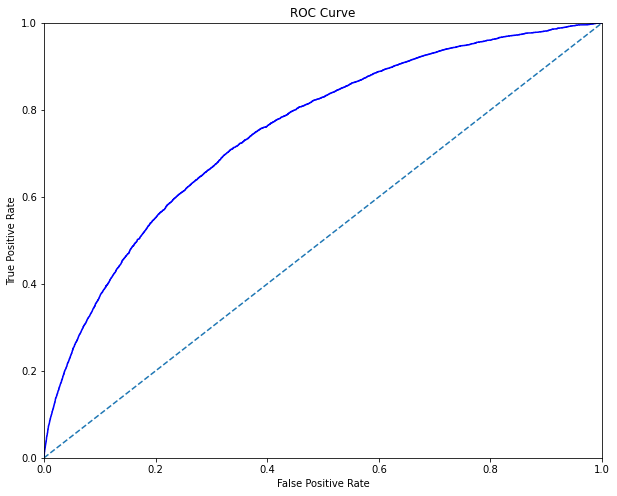

In [ ]:
# Biểu diễn đường roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(target_test, predicted_probas[:,1])
  
# Lưu biểu đồ vào p1
p1 = _plot_roc_curve(fpr, tpr, thres)

In [ ]:
from sklearn.metrics import auc
#0.7609513284243766
auc(fpr, tpr)

0.750918737405476

## LightGBM with KFold

In [ ]:
def kfold_lightgbm_sklearn(data, categorical_feature = None):
    df = data[data['TARGET'].notnull()]
    #test = data[data['TARGET'].isnull()]
    #print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    #sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)
        print('check')
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        #sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        print('pass')
        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        #gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(df['TARGET'], oof_preds))
    #test['TARGET'] = sub_preds.copy()

    # Get the average feature importance between folds
    #mean_importance = importance_df.groupby('feature').mean().reset_index()
    #mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    
    #return mean_importance

In [ ]:
# ------------------------- CONFIGURATIONS -------------------------

# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "../input/"
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 5
EARLY_STOPPING = 50

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

In [ ]:
#feat_importance = 
kfold_lightgbm_sklearn(app_train_top_features)
#print(feat_importance)

Training until validation scores don't improve for 50 rounds.
[400]	training's binary_logloss: 0.245448	training's auc: 0.769915	valid_1's binary_logloss: 0.252637	valid_1's auc: 0.743905
[800]	training's binary_logloss: 0.238153	training's auc: 0.787623	valid_1's binary_logloss: 0.249818	valid_1's auc: 0.748972
[1200]	training's binary_logloss: 0.233198	training's auc: 0.802752	valid_1's binary_logloss: 0.249013	valid_1's auc: 0.751433
[1600]	training's binary_logloss: 0.229007	training's auc: 0.816089	valid_1's binary_logloss: 0.248705	valid_1's auc: 0.7525
Early stopping, best iteration is:
[1733]	training's binary_logloss: 0.227714	training's auc: 0.820116	valid_1's binary_logloss: 0.248649	valid_1's auc: 0.752671
check
pass
Fold  1 AUC : 0.752671
Training until validation scores don't improve for 50 rounds.
[400]	training's binary_logloss: 0.245934	training's auc: 0.769129	valid_1's binary_logloss: 0.250553	valid_1's auc: 0.749257
[800]	training's binary_logloss: 0.238645	training